<a href="https://colab.research.google.com/github/Taeyoungleee/Dacon-dielectric-prediction/blob/main/%5BPrivate_5th%5D_Feature_Engineering_%2B_Ridge_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import pandas as pd
import random
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
# plt.rc('font', family='AppleGothic')
# from catboost import CatBoostClassifier

In [ ]:
class CFG:
    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
snp_info= pd.read_csv("/content/drive/MyDrive/data/유전체 정보 품종 분류/snp_info.csv")
train = pd.read_csv('/content/drive/MyDrive/data/유전체 정보 품종 분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/유전체 정보 품종 분류/test.csv')
sample_submission= pd.read_csv("/content/drive/MyDrive/data/유전체 정보 품종 분류/sample_submission.csv")

Dataset Info.

### train.csv [파일]
1. id : 개체 고유 ID
개체정보
2. father : 개체의 가계 고유 번호 (0 : Unknown)
3. mother : 개체의 모계 고유 번호 (0 : Unknown)
4. gender : 개체 성별 (0 : Unknown, 1 : female, 2 : male)
5. trait : 개체 표현형 정보
15개의 SNP 정보 : SNP_01 ~ SNP_15
6. class : 개체의 품종 (A,B,C)


### test.csv [파일]
1. id : 개체 샘플 별 고유 ID
개체정보
2. father : 개체의 가계 고유 번호 (0 : Unknown)
3. mother : 개체의 모계 고유 번호 (0 : Unknown)
4. gender : 개체 성별 (0 : Unknown, 1 : female, 2 : male)
5. trait : 개체 표현형 정보
15개의 SNP 정보 : SNP_01 ~ SNP_15


### snp_info.csv [파일]
15개의 SNP 세부 정보
1. name : SNP 명
2. chrom : 염색체 정보
3. cm : Genetic distance
4. pos : 각 마커의 유전체상 위치 정보


### sample_submission.csv [파일] - 제출 양식
1. id : 개체 샘플 별 고유 ID
2. class : 예측한 개체의 품종 (A,B,C)

In [ ]:
snp_info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


In [ ]:
train

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,...,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,class
0,TRAIN_000,0,0,0,2,G G,A G,A A,G A,C A,...,A A,G G,A A,G G,A G,A A,A A,A A,A A,B
1,TRAIN_001,0,0,0,2,A G,A G,C A,A A,A A,...,A A,G A,A A,A G,A A,G A,G G,A A,A A,C
2,TRAIN_002,0,0,0,2,G G,G G,A A,G A,C C,...,A A,G A,G A,A G,A A,A A,A A,A A,A A,B
3,TRAIN_003,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G G,A G,G G,G G,G G,A A,G G,A
4,TRAIN_004,0,0,0,2,G G,G G,C C,A A,C C,...,A A,A A,A A,G G,A A,A A,A G,A A,G A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,TRAIN_257,0,0,0,2,A G,A G,A A,G A,C C,...,A A,G A,A A,G G,A G,G A,A A,A A,A A,B
258,TRAIN_258,0,0,0,2,G G,A A,C A,A A,A A,...,G A,G A,A A,A G,A G,A A,A G,A A,G A,C
259,TRAIN_259,0,0,0,1,A G,G G,A A,G A,A A,...,G G,G A,G A,A A,G G,G G,G G,C A,G G,A
260,TRAIN_260,0,0,0,1,A A,G G,A A,G A,A A,...,G G,A A,G A,A G,A G,G A,G G,C A,G G,A


In [ ]:
test

,id,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,TEST_000,0,0,0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,TEST_001,0,0,0,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,TEST_002,0,0,0,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,TEST_003,0,0,0,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,TEST_004,0,0,0,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,TEST_170,0,0,0,2,A G,G G,C C,A A,C A,A G,A A,G G,A A,G G,G G,A A,A A,A A,G A
171,TEST_171,0,0,0,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,A G,A A,A A,A G,A A,G A
172,TEST_172,0,0,0,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,G G,A G,A A,A G,A A,G G
173,TEST_173,0,0,0,2,A G,G G,C A,G A,C C,G G,A A,G A,A A,G G,A G,A A,A A,A A,A A


In [ ]:
print(f"train : {train.shape}")
print(f"test : {test.shape}")
print(f"submission : {sample_submission.shape}")

train : (262, 21)
test : (175, 20)
submission : (175, 2)


In [ ]:
snp_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SNP_id  15 non-null     object 
 1   name    15 non-null     object 
 2   chrom   15 non-null     int64  
 3   cm      15 non-null     float64
 4   pos     15 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 728.0+ bytes


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   father  262 non-null    int64 
 2   mother  262 non-null    int64 
 3   gender  262 non-null    int64 
 4   trait   262 non-null    int64 
 5   SNP_01  262 non-null    object
 6   SNP_02  262 non-null    object
 7   SNP_03  262 non-null    object
 8   SNP_04  262 non-null    object
 9   SNP_05  262 non-null    object
 10  SNP_06  262 non-null    object
 11  SNP_07  262 non-null    object
 12  SNP_08  262 non-null    object
 13  SNP_09  262 non-null    object
 14  SNP_10  262 non-null    object
 15  SNP_11  262 non-null    object
 16  SNP_12  262 non-null    object
 17  SNP_13  262 non-null    object
 18  SNP_14  262 non-null    object
 19  SNP_15  262 non-null    object
 20  class   262 non-null    object
dtypes: int64(4), object(17)
memory usage: 43.1+ KB


### SNP_info 분석

In [ ]:
snp_info

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


#### SNP chrom별로 분류해 데이터 살펴보기

Text(0.5, 1.0, 'chrom 종류별 개수')

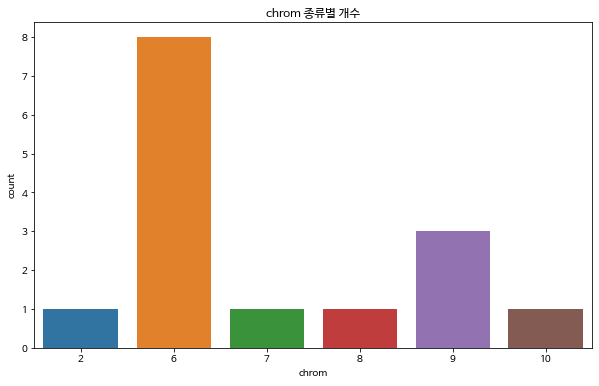

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='chrom', data=snp_info)
plt.title('chrom 종류별 개수')

Text(0.5, 1.0, '유전거리 분포')

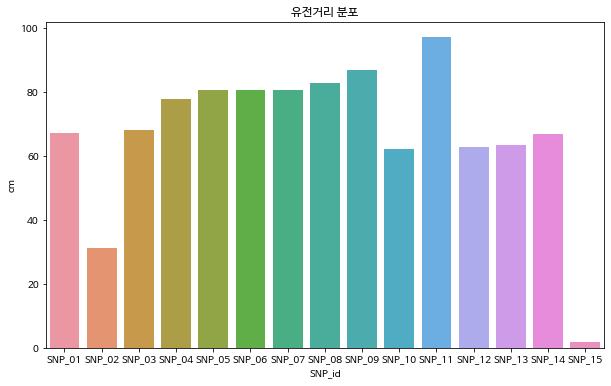

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='cm', data=snp_info)
plt.title('유전거리 분포')

Text(0.5, 1.0, '각 마커 유전체상 위치정보')

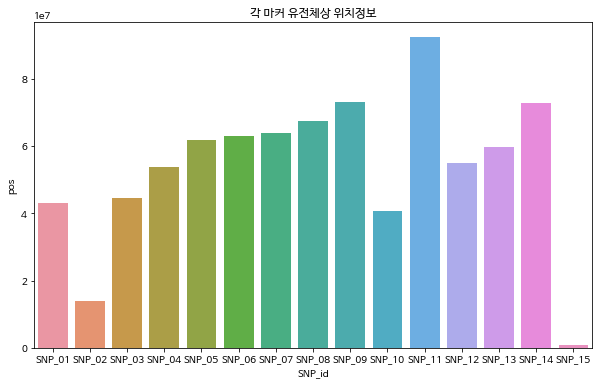

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='pos', data=snp_info)
plt.title('각 마커 유전체상 위치정보')

In [ ]:
snp_6=snp_info[snp_info['chrom']==6]
snp_6

,SNP_id,name,chrom,cm,pos
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.1567,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.2892,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.8749,53826064
4,SNP_05,BovineHD0600017032,6,80.5015,61779512
5,SNP_06,BovineHD0600017424,6,80.5954,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.7800,64037334
7,SNP_08,BovineHD0600018638,6,82.6856,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.8740,73092782


In [ ]:
snp_9=snp_info[snp_info['chrom']==9]
snp_9

,SNP_id,name,chrom,cm,pos
11,SNP_12,Hapmap32827-BTA-146530,9,62.7463,55007839
12,SNP_13,BTB-00395482,9,63.4181,59692848
13,SNP_14,Hapmap40256-BTA-84189,9,66.8197,72822507


Text(0.5, 1.0, 'chrom=6 인 SNP의 유전거리')

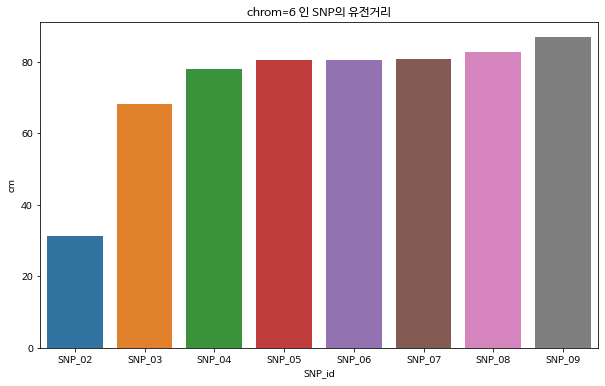

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='cm', data=snp_6)
plt.title('chrom=6 인 SNP의 유전거리')

Text(0.5, 1.0, 'chrom=6 인 SNP의 유전체상 위치정보')

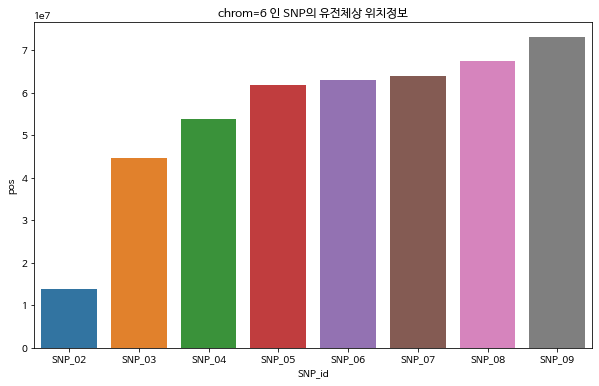

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='pos', data=snp_6)
plt.title('chrom=6 인 SNP의 유전체상 위치정보')

Text(0.5, 1.0, 'chrom=9 인 SNP의 유전거리')

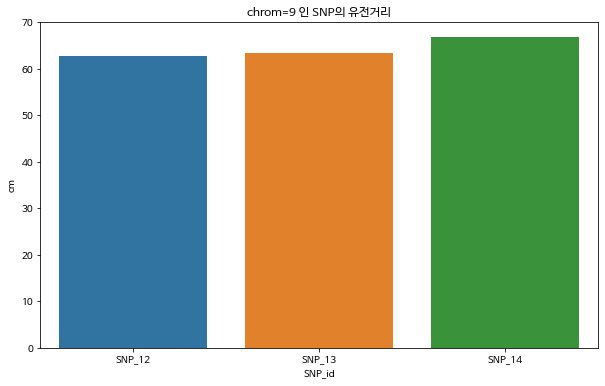

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='cm', data=snp_9)
plt.title('chrom=9 인 SNP의 유전거리')

Text(0.5, 1.0, 'chrom=9 인 SNP의 유전체상 위치정보')

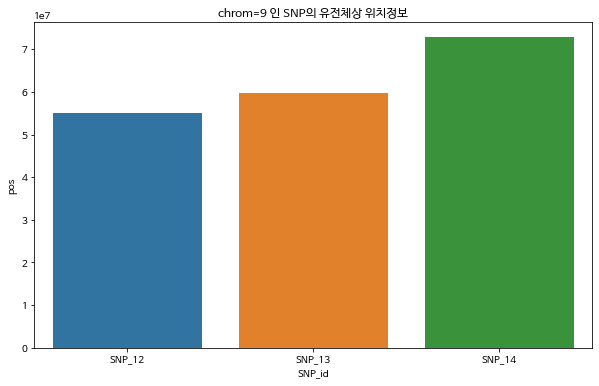

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='SNP_id', y='pos', data=snp_9)
plt.title('chrom=9 인 SNP의 유전체상 위치정보')

### 숫자형으로 변경

In [ ]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

In [ ]:
train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

In [ ]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

In [ ]:
snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

In [ ]:
train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [ ]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

In [ ]:
train_x

,father,mother,gender,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,0,0,0,2,5,1,0,4,2,0,0,5,0,5,1,0,0,0,0
1,0,0,0,2,1,1,2,0,0,1,0,4,0,1,0,4,5,0,0
2,0,0,0,2,5,5,0,4,3,5,0,4,4,1,0,0,0,0,0
3,0,0,0,1,0,5,0,4,0,5,5,0,5,1,5,5,5,0,5
4,0,0,0,2,5,5,3,0,3,0,0,0,0,5,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0,0,0,2,1,1,0,4,3,1,0,4,0,5,1,4,0,0,0
258,0,0,0,2,5,0,2,0,0,1,4,4,0,1,1,0,1,0,4
259,0,0,0,1,1,5,0,4,0,1,5,4,4,0,5,5,5,2,5
260,0,0,0,1,0,5,0,4,0,5,5,0,4,1,1,4,5,2,5


In [ ]:
snp_le.classes_

array(['A A', 'A G', 'C A', 'C C', 'G A', 'G G'], dtype='<U3')

In [ ]:
train_num=train_x.drop(columns=['father', 'mother', 'gender'])
train_num

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,2,5,1,0,4,2,0,0,5,0,5,1,0,0,0,0
1,2,1,1,2,0,0,1,0,4,0,1,0,4,5,0,0
2,2,5,5,0,4,3,5,0,4,4,1,0,0,0,0,0
3,1,0,5,0,4,0,5,5,0,5,1,5,5,5,0,5
4,2,5,5,3,0,3,0,0,0,0,5,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,1,1,0,4,3,1,0,4,0,5,1,4,0,0,0
258,2,5,0,2,0,0,1,4,4,0,1,1,0,1,0,4
259,1,1,5,0,4,0,1,5,4,4,0,5,5,5,2,5
260,1,0,5,0,4,0,5,5,0,4,1,1,4,5,2,5


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


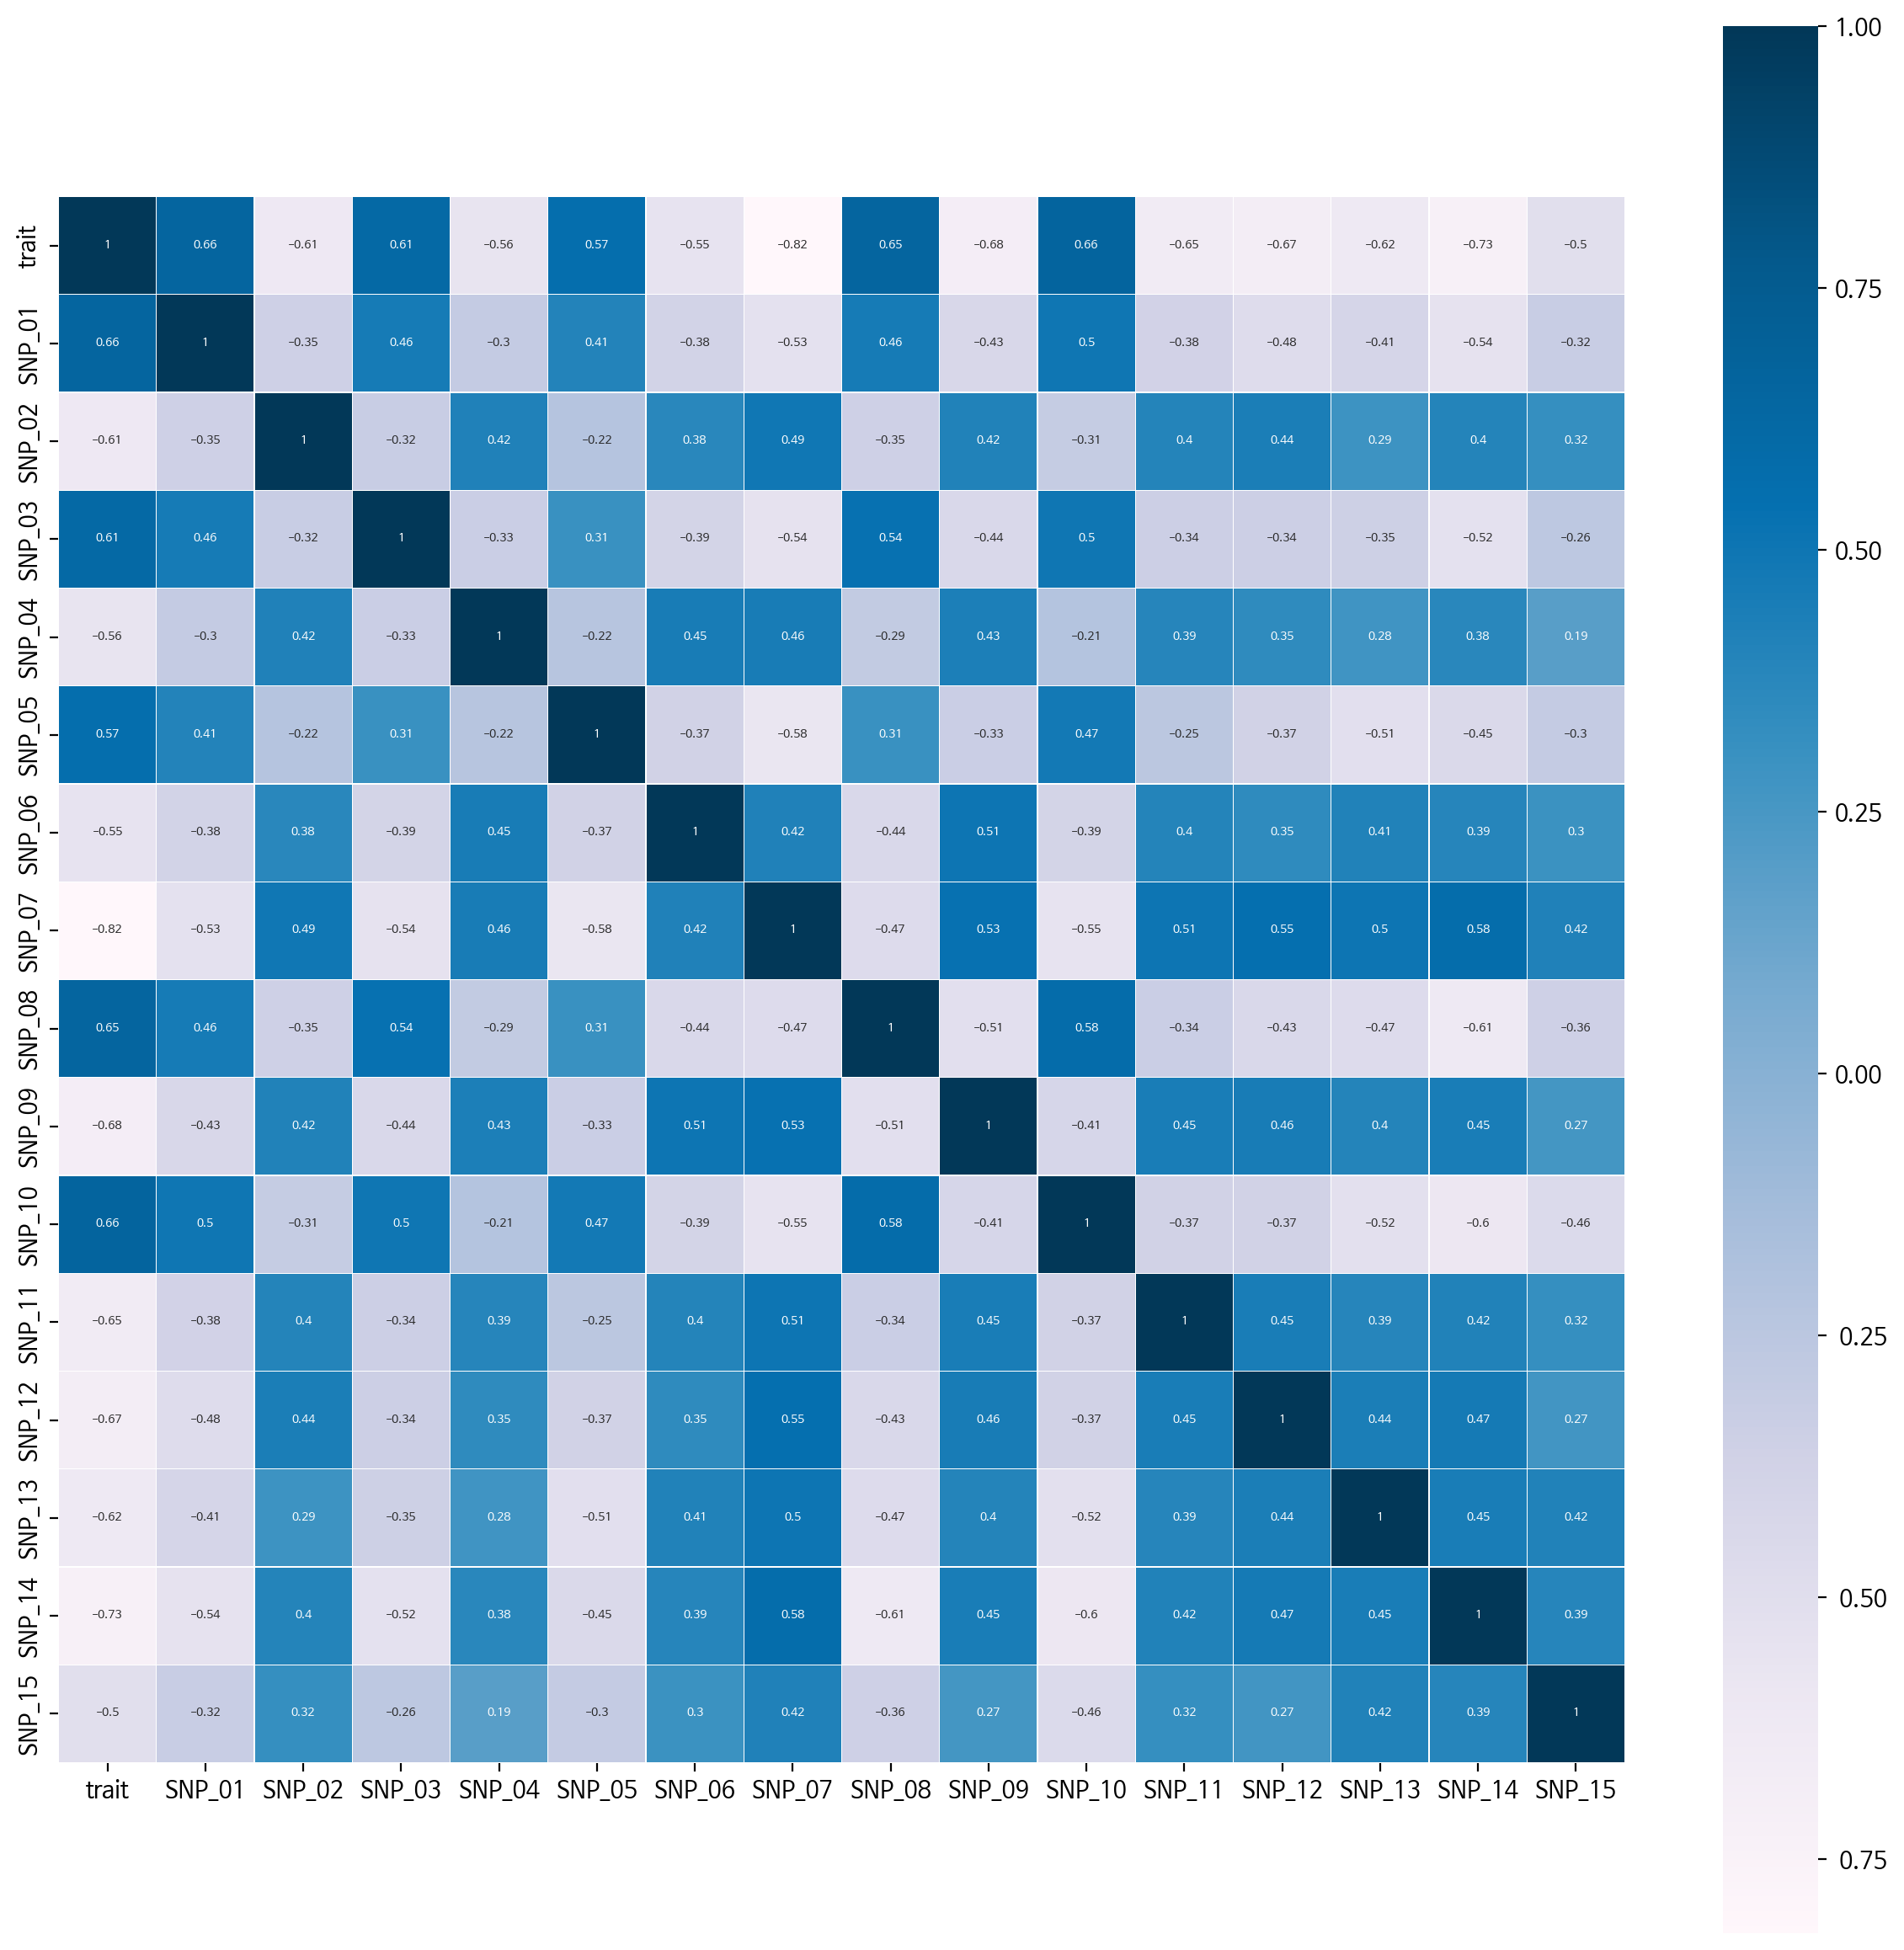

In [ ]:
colormap = plt.cm.PuBu
plt.figure(figsize=(15,15), dpi=200)

sns.heatmap(train_num.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 5})

### 모델 돌려보기

In [ ]:
model_y=pd.DataFrame(train_y, columns=['class'])
model_y

,class
0,1
1,2
2,1
3,0
4,2
...,...
257,1
258,2
259,0
260,0


In [ ]:
model_X=train_x.drop(columns=['father','mother','gender','SNP_01','SNP_02','SNP_03','SNP_09','SNP_10', 'SNP_11', 'SNP_12', 'SNP_13','SNP_14', 'SNP_15'])
model_X

,trait,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08
0,2,4,2,0,0,5
1,2,0,0,1,0,4
2,2,4,3,5,0,4
3,1,4,0,5,5,0
4,2,0,3,0,0,0
...,...,...,...,...,...,...
257,2,4,3,1,0,4
258,2,0,0,1,4,4
259,1,4,0,1,5,4
260,1,4,0,5,5,0


### Automl 사용해 제출해보기

In [ ]:
test_x=test_x.drop(columns=['father','mother','gender','SNP_01','SNP_02','SNP_03','SNP_09','SNP_10', 'SNP_11', 'SNP_12', 'SNP_13','SNP_14', 'SNP_15'])

In [ ]:
test_x

,trait,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08
0,1,4,0,1,5,4
1,2,5,3,0,0,0
2,2,0,2,1,0,0
3,2,0,3,0,0,0
4,1,5,0,5,5,0
...,...,...,...,...,...,...
170,2,0,2,1,0,5
171,2,0,2,1,0,0
172,2,0,2,1,0,0
173,2,4,3,5,0,4


In [ ]:
model_y

,class
0,1
1,2
2,1
3,0
4,2
...,...
257,1
258,2
259,0
260,0


In [ ]:
model_X

,trait,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08
0,2,4,2,0,0,5
1,2,0,0,1,0,4
2,2,4,3,5,0,4
3,1,4,0,5,5,0
4,2,0,3,0,0,0
...,...,...,...,...,...,...
257,2,4,3,1,0,4
258,2,0,0,1,4,4
259,1,4,0,1,5,4
260,1,4,0,5,5,0


In [ ]:
model_train=pd.concat([model_X, model_y], axis=1)
model_train

,trait,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,class
0,2,4,2,0,0,5,1
1,2,0,0,1,0,4,2
2,2,4,3,5,0,4,1
3,1,4,0,5,5,0,0
4,2,0,3,0,0,0,2
...,...,...,...,...,...,...,...
257,2,4,3,1,0,4,1
258,2,0,0,1,4,4,2
259,1,4,0,1,5,4,0
260,1,4,0,5,5,0,0


In [ ]:
pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.4.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
xarray-einstats 0.4.0 requires scipy>=1.6, but you have scipy 1.5.4 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jaxlib 0.3.25+cuda11.cudnn805 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
jax 0.3.25 requires numpy>=1.20, but you 

In [ ]:
pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.20.0-cp38-cp38-manylinux2010_x86_64.whl (15.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.4.0 requires scipy>=1.6, but you have scipy 1.5.4 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.9 which is incompatible.
cmdstanpy 1.0.8 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.


In [ ]:
pip install scikit-learn==0.23.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pycaret.classification import *
setup_clf = setup(data=model_train, target='class',
                  session_id=777, fold_shuffle=True)

,Description,Value
0,session_id,777
1,Target,class
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(262, 7)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='class',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strate...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best_model = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9564,0.9620,0.9613,0.9617,0.9560,0.9333,0.9365,0.024
ridge,Ridge Classifier,0.9509,0.0000,0.9585,0.9597,0.9505,0.9248,0.9300,0.024
et,Extra Trees Classifier,0.9512,0.9754,0.9550,0.9583,0.9505,0.9248,0.9293,0.325
rf,Random Forest Classifier,0.9456,0.9758,0.9508,0.9521,0.9451,0.9162,0.9203,0.392
gbc,Gradient Boosting Classifier,0.9401,0.9767,0.9460,0.9485,0.9395,0.9080,0.9133,0.368
lr,Logistic Regression,0.9345,0.9840,0.9391,0.9452,0.9342,0.8995,0.9055,0.461
svm,SVM - Linear Kernel,0.9342,0.0000,0.9466,0.9511,0.9329,0.8998,0.9100,0.030
lightgbm,Light Gradient Boosting Machine,0.9289,0.9818,0.9371,0.9375,0.9285,0.8911,0.8963,0.225
knn,K Neighbors Classifier,0.9193,0.9695,0.9233,0.9255,0.9167,0.8748,0.8811,0.024
lda,Linear Discriminant Analysis,0.9126,0.9818,0.9052,0.9374,0.9128,0.8650,0.8770,0.021


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=777, splitter='best')
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
fold=StratifiedKFold(n_splits=5, shuffle=True)
ridge = create_model('ridge', fold=fold)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8919,0.0,0.8944,0.8960,0.8904,0.8345,0.8383
1,0.9730,0.0,0.9792,0.9751,0.9731,0.9585,0.9596
2,0.9730,0.0,0.9792,0.9751,0.9731,0.9585,0.9596
3,0.9444,0.0,0.9556,0.9524,0.9446,0.9155,0.9198
4,0.8889,0.0,0.9056,0.8965,0.8892,0.8310,0.8349
Mean,0.9342,0.0,0.9428,0.9390,0.9341,0.8996,0.9024
Std,0.0373,0.0,0.0361,0.0359,0.0376,0.0568,0.0557


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_rd = tune_model(ridge, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8421,0.0,0.8333,0.8852,0.8283,0.7522,0.7846
1,0.8947,0.0,0.9028,0.8947,0.8947,0.8390,0.8390
2,1.0000,0.0,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9444,0.0,0.9524,0.9524,0.9444,0.9163,0.9206
4,0.9444,0.0,0.9524,0.9524,0.9444,0.9163,0.9206
5,1.0000,0.0,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,0.0,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.8889,0.0,0.9167,0.9167,0.8889,0.8302,0.8462
8,0.8333,0.0,0.8472,0.8346,0.8307,0.7379,0.7415


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
evaluate_model(tuned_rd)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
final_model = finalize_model(tuned_rd)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001)
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001), fold=None, round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=True, verbose=False, system=False, metrics=None, experiment_

In [ ]:
prediction = predict_model(final_model, data = test_x)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RidgeClassifier(alpha=4.24, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=777, solver='auto',
                tol=0.001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


In [ ]:
prediction

,trait,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,Label
0,1,4,0,1,5,4,0
1,2,5,3,0,0,0,1
2,2,0,2,1,0,0,2
3,2,0,3,0,0,0,2
4,1,5,0,5,5,0,0
...,...,...,...,...,...,...,...
170,2,0,2,1,0,5,1
171,2,0,2,1,0,0,2
172,2,0,2,1,0,0,2
173,2,4,3,5,0,4,1


In [ ]:
prediction['Label']

0      0
1      1
2      2
3      2
4      0
      ..
170    1
171    2
172    2
173    1
174    1
Name: Label, Length: 175, dtype: int64

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/data/유전체 정보 품종 분류/sample_submission.csv")

submit['class'] = class_le.inverse_transform(prediction['Label'])

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/dacon/submit.csv', index=False)